In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing de la data

### Import de la data

In [2]:
file_name = 'consommation-quotidienne-brute-regionale.csv'  # 'consommation-quotidienne-brute.csv'

df_original = pd.read_csv(file_name, sep=';')

### Trier par date et heure croissant

In [3]:
df_filtered = df_original.sort_values(by=['Date', 'Heure'])

### Drop des colomnes inutiles

In [4]:
df_filtered = df_filtered.drop(
    [
        'Date - Heure',
        'Code INSEE région',
        'Statut - GRTgaz',
        'Statut - Teréga',
        'Statut - RTE'
    ],
    axis=1
)

### Drop des champs NAN

In [5]:
df_filtered = df_filtered.dropna(subset='Consommation brute totale (MW)')

### Convertion au format datetime

In [6]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

## Création des datasets à l'échelle nationale

In [7]:
columns_brute_gaz = ['Date', 'Heure', 'Région', 'Consommation brute gaz totale (MW PCS 0°C)']
columns_brute_electricite = ['Date', 'Heure', 'Région', 'Consommation brute électricité (MW) - RTE']
columns_brute_totale = ['Date', 'Heure', 'Région', 'Consommation brute totale (MW)']

df_brute_gaz = df_filtered[columns_brute_gaz]
df_brute_electricite = df_filtered[columns_brute_electricite]
df_brute_totale = df_filtered[columns_brute_totale]

df_brute_electricite_full = df_filtered[columns_brute_electricite].dropna(subset='Consommation brute électricité (MW) - RTE')

### moyennage à la semaine

In [8]:
# Select only the necessary columns
df_selected = df_brute_totale[['Date', 'Consommation brute totale (MW)']]

# Set the 'Date' column as the index first, then resample
# df_weekly_avg = df_selected.set_index('Date').resample('W').mean()
df_weekly_avg = df_selected.set_index('Date').resample('W').mean()

# First, reset the index if the dates are in the index
if isinstance(df_weekly_avg.index, pd.DatetimeIndex):
    df_weekly_avg = df_weekly_avg.reset_index()

# Create a properly structured DataFrame
df_weekly_avg = pd.DataFrame({
    'Date': df_weekly_avg['Date'].values,
    'Consommation brute totale (MW)': df_weekly_avg['Consommation brute totale (MW)'].values.flatten()
})

# Résidu

In [9]:
from statsmodels.tsa.seasonal import STL
import statsmodels

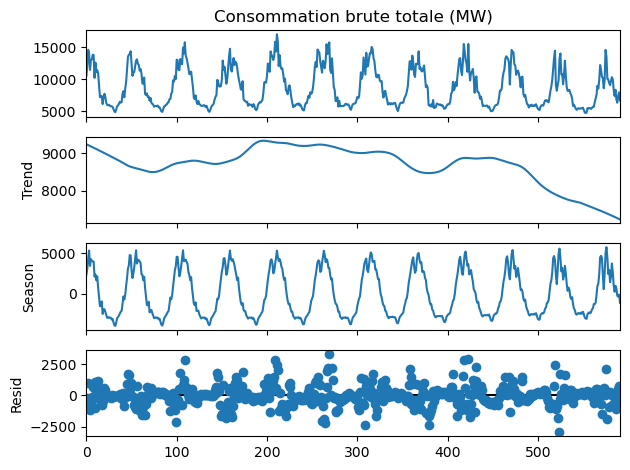

In [10]:
# For annual seasonality:
stl = statsmodels.tsa.seasonal.STL(df_weekly_avg['Consommation brute totale (MW)'], seasonal=11, period=52)
res = stl.fit()
fig = res.plot()

In [11]:
residu = res.resid

# Garch

In [20]:
from arch import arch_model

ModuleNotFoundError: No module named 'arch'

### Model specification

In [ ]:
distribution = "T"  # On estime la distribution des résidus comme suivant une loi de Student (peut être "normal")
mean_model = "constant"
volatility = "GARCH"

basic_gm = arch_model(residu, p=1, q=1, mean="constant", vol="GARCH", dist="normal")

### Model fitting

In [ ]:
gm_result = basic_gm.fit(update_freq=4)

In [ ]:
# Estimé par maximum de vraisemblance :
# choix des paramètres qui permettent au modèle
# de générer avec le max de proba les données
print(gm_result.params)

In [ ]:
gm_result.plot()

### Model forecasting

In [ ]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon=5)
print(gm_forecast.variance[-1:])

## GARCH(1,1) avec Student

In [ ]:
distribution = "T"  # On estime la distribution des résidus comme suivant une loi de Student (peut être "normal")
mean_model = "constant"
volatility = "GARCH"

basic_gm = arch_model(residu, p=1, q=1, mean="constant", vol="GARCH", dist="T")

gm_result = basic_gm.fit(update_freq=4)
print(gm_result.params)

gm_result.plot()

## GARCH(17,1)

In [ ]:
distribution = "T"  # On estime la distribution des résidus comme suivant une loi de Student (peut être "normal")
mean_model = "constant"
volatility = "GARCH"

basic_gm = arch_model(residu, p=17, q=1, mean="constant", vol="GARCH", dist="normal")

gm_result = basic_gm.fit(update_freq=4)
print(gm_result.params)

gm_result.plot()

In [ ]:
gm_forecast = gm_result.forecast(horizon=200)

In [ ]:
predictions = gm_forecast.variance.melt(id_vars=[], var_name="D+n", value_name="volatility")
predictions.head()

In [ ]:
predictions.plot(legend=True, grid=True, rot=60, xlabel='')

dans leur notebook il faisait vairer p pour voir s'ils obtenait de meilleurs prédictions